# 导入所用的包

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import os
import re
import json
from sklearn.preprocessing import MinMaxScaler


# 读入所用的数据文件

In [2]:
# 文件读入
fileName = '.\\id1.csv'
fileData = []
fileData = pd.read_csv(fileName)


# 实验用参数

In [3]:
start_time="2018/7/4 0:0:0"
end_time="2019/7/15 0:0:0"

mask_train="2019-01-08"
mask_test="2019-01-19"
epochs=600
batch_size=1000
learning_rate=0.125

useRegularizer=True   #是否使用正则化项
l2_regularizer=0.01
op="sgd"
structure=[[64,"relu"],[40,"relu"],[40,"relu"],[14,"relu"],[10,"relu"],[8,"relu"],[1,"linear"]]

# 创建目录和excel

In [4]:
import os
now=int(time.time())
filePath=str(now)
fatherPath=os.getcwd()
currentPath=fatherPath+"\\testData\\"+filePath
os.mkdir(currentPath)

# 数据预处理

In [5]:
from preprocess import preprocess
predict_hour=4
if not os.path.exists("dataSet.npy"):
    preprocess(fileData,start_time,end_time,predict_hour)

# 分割数据集

In [6]:
def seperate(op=1,ratio=0.8,num_train=2000):
    dataFinal = np.load("dataSet.npy").astype(float)
    if op==1:
        np.random.shuffle(dataFinal)# 打乱data的顺序
        
        # 针对不同模型的数据预处理
        # 归一化
        BPNNscaler = MinMaxScaler().fit(dataFinal)
        yScaler = MinMaxScaler().fit(dataFinal[:,0].reshape(-1, 1))
        data = BPNNscaler.transform(dataFinal)
       
        
        # 划分训练集和数据集
        maskTrain = np.array(dataFinal[:,1] <= time.mktime(time.strptime(mask_train, "%Y-%m-%d")), dtype='bool')
        X_train = data[maskTrain, 1:]
        Y_train = data[maskTrain, 0]
        maskTest = np.array(dataFinal[:,1] <= time.mktime(time.strptime(mask_test, "%Y-%m-%d")), dtype='bool')
        X_test = data[maskTest & ~maskTrain, 1:]
        Y_test = data[maskTest & ~maskTrain, 0]
    elif op==2:
        #按比例划分数据集
        np.random.shuffle(dataFinal)# 打乱data的顺序
        # 针对不同模型的数据预处理
        # 归一化
        BPNNscaler = MinMaxScaler().fit(dataFinal)
        yScaler = MinMaxScaler().fit(dataFinal[:,0].reshape(-1, 1))
        data = BPNNscaler.transform(dataFinal)
        length=int(ratio*len(data))
        X_train = data[:length, 1:]
        Y_train = data[:length, 0]
        X_test = data[length, 1:]
        Y_test = data[length, 0]
    else:
        #近似于分割出一个月的前几天，后几天作为测试集
        # 归一化
        BPNNscaler = MinMaxScaler().fit(dataFinal)
        yScaler = MinMaxScaler().fit(dataFinal[:,0].reshape(-1, 1))
        data = BPNNscaler.transform(dataFinal)
        num_test=int(num_train*(1-ratio))
        num_total=num_train+num_test
        mask=[]
        for i in range(len(data)):
            if(i%num_total<num_train):
                mask.append(True)
            else:
                mask.append(False)
        mask=np.array(mask)
        X_train = data[mask, 1:]
        Y_train = data[mask, 0]
        X_test = data[~mask, 1:]
        Y_test = data[~mask, 0]
    return X_train,Y_train,X_test,Y_test,yScaler

In [7]:
X_train,Y_train,X_test,Y_test,yScaler=seperate(op=1)

# 建立模型

引入所需的包

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
from keras import regularizers
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.grid_search import GridSearchCV

In [10]:
#定义KerasRegressor所需要的函数参数
def create_model(structure=structure,learning_rate=learning_rate):
    model = Sequential()
    model.add(Dense(structure[0][0], input_dim=len(X_train[0]), activation=structure[0][1]))#,W_constraint=maxnorm(weight_constraint)
    for i in range(len(structure)):
        if i is 0:
            continue
        if useRegularizer:
            model.add(Dense(structure[i][0],kernel_regularizer=regularizers.l2(l2_regularizer),activation=structure[i][1]))
            #model.add(Dropout(dropout_rate))
        else:
            model.add(Dense(structure[i][0],activation=structure[i][1]))
            #model.add(Dropout(dropout_rate))
    sgd = optimizers.SGD(lr=0.1)
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss="mean_squared_error", optimizer=sgd,metrics=["accuracy"])
    return model

Using TensorFlow backend.


# 网格搜索+训练

In [20]:
model_op=2

# 1 :用keras搭建的神经网络
# 2 :GBDT

In [21]:
# 神经网络所用的参数
#batch_size = [10000,20000]
#learning_rate = [0.01]
#activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]



if model_op==1:
    model = KerasRegressor(build_fn=create_model,epochs=200,verbose=1)
    # 神经网络所用的参数
    param_grid = {'batch_size':range(10000,20000,5000),'learning_rate':np.linspace(0.01,0.02,1)}
elif model_op==2:
    model=GradientBoostingRegressor(random_state=20)
    #GBDT所用的参数
    param_grid = {'n_estimators':range(20,81,80)}


grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1,scoring="neg_mean_absolute_error")
grid_result = grid.fit(X_train, Y_train)

In [22]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))
    
model=grid.best_estimator_

Best: -0.037226 using {'n_estimators': 20}
-0.037226 (0.000135) with: {'n_estimators': 20}


D:\anaconda\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


# 储存训练结果

In [ ]:
cv_result = pd.DataFrame.from_dict(grid.cv_results_)
cv_result.to_csv(currentPath+'\\train models.csv',index=False,header=True)

# 预测、绘图

In [23]:
model=grid.best_estimator_

D:\anaconda\lib\site-packages\numpy\lib\function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
D:\anaconda\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
D:\anaconda\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
R^2:-0.11556368803102379
Mean:1.4621863696316124
Test loss:2.755178636493979


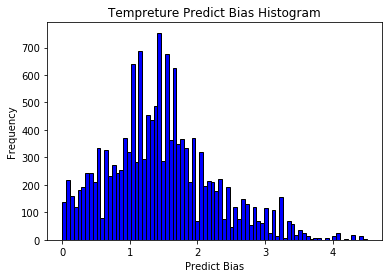

In [31]:
Y_predict  = yScaler.inverse_transform(model.predict(X_test).reshape(-1, 1))
Y_true = yScaler.inverse_transform(Y_test.reshape(-1, 1))
test_loss=np.sum(np.square(Y_predict - Y_true))/len(Y_true)
SStot = np.sum(np.square(Y_true-np.mean(Y_true)))
SSres = np.sum(np.square(Y_true-Y_predict))
R2 = 1-SSres/SStot
print("R^2:" + str(R2))
print("Mean:" + str(np.mean(np.abs(Y_predict - Y_true))))
print("Test loss:"+str(test_loss))
plt.xlabel('Predict Bias')
plt.ylabel('Frequency')
plt.title('Tempreture Predict Bias Histogram')
plt.hist(np.abs(Y_predict - Y_true), bins=80, facecolor="blue", edgecolor="black")
plt.savefig(currentPath+"\\Tempreture Predict Bias Histogram.png")
plt.show()
plt.close()

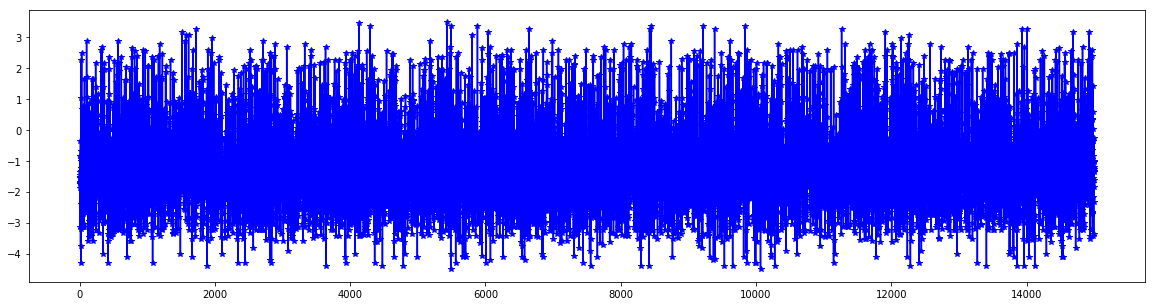

In [25]:
fig=plt.figure(figsize=(20,5),facecolor='white')
plt.plot(Y_true - Y_predict,marker='*',color='b')
save = pd.DataFrame(Y_true)
save.to_csv(currentPath+'\\Y_true.csv',index=False,header=False)
save = pd.DataFrame(Y_predict)
save.to_csv(currentPath+'\\Y_predict.csv',index=False,header=False)

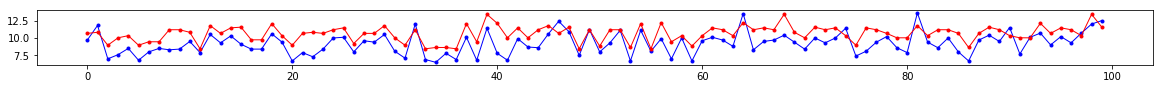

In [32]:
start=2300
points=100
end=start+points

width=20
height=1
linewidth=1

fig=plt.figure(figsize=(width,height),facecolor='white')
plt.plot(Y_true[start:end],linewidth=linewidth,marker='.',color='b')
plt.plot(Y_predict[start:end],linewidth=linewidth,marker='.',color='r')

In [19]:
from functions import create_file
message="R^2 : "+str(R2)+"\n"+"Mean : "+str(np.mean(np.abs(Y_predict - Y_true)))+"\n"+"Test loss:"+str(test_loss)
create_file(currentPath+"\\result.txt",message)